# QD heat engine load matching workbook

This document can be used to estimate the ideal load resistor for a QD heat engine if the temperatures of the leads and the plateau currents are known. Four important assumptions are made: (1) $\Gamma_\mathrm{L} = \Gamma_\mathrm{R}$ across the left and right barrier and (2) the charging energy is sufficiently large such that thermoelectric signals for inidividual charge state transitions do not overlap and (3) excited states play no role and (4) lifetime broadening is negligible. the calculations are based on QmeQ and RTD.

Various parameters can be set to match an initial calculation of the thermocurrent to 'raw' experimental data. This includes providing plateau currents, specifying the load resistor in the circuit (note: if R = 0 is specified the 10 kOhm input impedance of a Femto current preamp on a 1nA/V gain is used), the lever arm of the gate, a voltage divider on the gate voltage source as well as a voltage offset (at which gate voltage is the resonance found?) and finally specification of the $0 \to 1$ or $1 \to 2$ charge state transition. If these parameters are supplied, temperatures can be manually varied to match the experimentally observed signal before calculation of the ideal load resistor for peak power and efficiency.

First, we have to supply our parameters:

In [32]:
TL = 2.2  # Temperature left reservoir in [K]
TR = 1.9  # Temperature right reservoir in [K]
I_plateau = 5e-9  # Plateau current in [A]

## Specify experimental details for better calculation to experiment matching:
R_load = 1e6  # Load resistor in [Ohm]
ag = 0.0096  # Lever arm of the gate in [eV/V]
divider = 1  # Voltage divider on gate voltage source
offset = -0.575  # Signal offset in [V]

## Specify which charge state transition is to be considered:
ChargeStateTransition = 1  # 0: 0->1 transition; 1: 1->2 transition

The next cell will estimate the tunnel couplings and plot a first thermoelectric (TE) current curve. This curve can be used to manually tune the parameters supplied above to match the experiment:

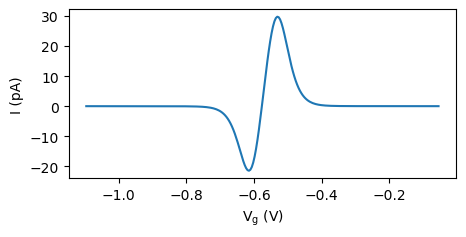

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import qmeq
from tqdm import tqdm
from scipy.constants import e, k, hbar
import scipy.optimize as optimize
import warnings
import math as math
import joblib
from joblib import delayed, Parallel


##  Define the functions that will be required later on:

# Function to calciulate the current through a given qmeq system
def current(system, Vbias, Vg, leads=[0,1]): 
    # Rescale input temperatures
    T_L, T_R = TL*1000*k/e, TR*1000*k/e

    system.change(mulst={0:-Vbias/2, 1:-Vbias/2, 2:Vbias/2, 3:Vbias/2})
    system.change(hsingle={(0,0):-Vg, (1,1):-Vg})

    # Solve system & calculate current:  
    system.solve()
    I, Q = 0, 0
    for l in leads:
        I += system.current[l]
        Q += system.heat_current[l]
    return I,Q

# Function to generate QmeQ system:
def Anderson_model(TL, TR, Gamma, U=10, Vg=0):

    nsingle, nleads = 2, 4
    
    G1, G2 = 1000*(hbar*Gamma)/e, 1000*(hbar*Gamma)/e    
    T_L, T_R = TL*1000*k/e, TR*1000*k/e
    U = U
    
    # Assign tunnel couplings dependent on gate voltage:
    tl, tr = np.sqrt(G1/2/np.pi), np.sqrt(G2/2/np.pi)
        
    tlst = {0:T_L, 1:T_L, 2:T_R, 3:T_R}
    tleads = {(0,0): tl, (1,1): tl, (2,0): tr, (3,1): tr}
    coulomb = {(0,1,1,0): U}
    mulst = {0:0, 1:0, 2:0, 3:0}
    hsingle = {(0,0):-Vg, (1,1):-Vg}

    system = qmeq.Builder(nsingle, hsingle, coulomb,
                          nleads, tleads, mulst, tlst, 5e5,
                          kerntype='RTD', itype=1)
    return system 


# Define functions for self-consistant solution of I_QD(V_QD )+ V_QD/R = 0
def func_root(Vbias, Vg, system, R=1e6):
    I = current(system, 1000*Vbias, Vg, leads=[2,3])[0]*1e-12*1.E9*e**2/hbar/(1)  # Current in A
    if R == 0:
        R_load = 10e3
    else:
        R_load = R
    I += Vbias/R_load
    return I

def voltage_R(Vg, system, R=1.09e6):
    result = optimize.root_scalar(func_root, args=(Vg, system, R),
                                  method='brentq', bracket=[-200, 200])
    return result.root # Return in V - Careful: other functions expect voltages in mV!


def thermocurrent(system, Vg, R=1e6):
    Ith = []
    Ith_scaled = []
    Vth = []
    Q = []
    for i in Vg:
        VR = voltage_R(i, system, R) # in V
        Vth.append(VR) # in V
        if TR > TL:  # This was the old default:
            I_tmp, Q_tmp = current(system, 1000*VR, i, leads=[2,3]) # Take hot lead for Q!
            Ith.append(I_tmp)
            Ith_scaled.append(I_tmp*1.E9*e**2/hbar/(1))  # Adjust sign dependent on choice of leads
            Q.append(Q_tmp)
        elif TR <= TL:
            I_tmp, Q_tmp = current(system, 1000*VR, i, leads=[0,1]) # Take hot lead for Q!
            Ith.append(-I_tmp)
            Ith_scaled.append(-I_tmp*1.E9*e**2/hbar/(1))  # Adjust sign dependent on choice of leads
            Q.append(-Q_tmp)
    return np.asarray(Ith_scaled), np.asarray(Q), np.asarray(Vth), np.asarray(Ith)


## Translate peak current to Gamma: (Note: This is an estimate, assuming equal Gammas across both barriers)
a = I_plateau/(2*e)
b = -I_plateau/(2*e)
Gamma = (3*a*b)/(-a+2*b)


## Calculate thermocurrent:
if ChargeStateTransition == 0:
    Eg = np.linspace(-5,5, 250)
elif ChargeStateTransition == 1:
    Eg =  np.linspace(-5,5, 250)+10  # Shift by charging energy
else:
    print('Undefined charge state transition. Use default setting 0.')
    Eg = np.linspace(-5,5, 250)

system = Anderson_model(TL, TR, Gamma)
I_th,_,_,_ = thermocurrent(system, Eg, R=R_load)

## Plot thermocurrent:
plt.figure(figsize=(5,2.2))
if ChargeStateTransition == 1:
    Vg = np.asarray(Eg)-10
else:
    Vg = np.asarray(Eg)

if ag == 1 and divider == 1:
    plt.plot(Vg+offset, I_th)
    plt.xlabel(r'e$\alpha_{\mathrm{g}}\mathrm{V_g}$ (meV)')
    plt.ylabel(r'I (pA)')
else:
    plt.plot((Vg/1000)/(divider*ag)+offset, I_th)
    plt.xlabel(r'$\mathrm{V_g}$ (V)')
    plt.ylabel(r'I (pA)')
plt.show()

Finally, the next cell will probe various load resistors and plot the resulting peak efficiency $\eta$ and power $\mathrm{P_{max}}$. Note that this can be slow.

In [34]:
# Define list of load resistors to probe:
R_list = [0.1e6, 0.25e6, 0.5e6, 1e6, 2.5e6, 5e6, 7.5e6, 1e7, 2.5e7, 5e7, 1e8, 2.5e8, 5e8, 1e9]

# Create new system    
system2 = Anderson_model(TL, TR, Gamma)  # Create system

# Calculate Carnot efficiency
nC = (TR-TL)/TR

# loop to calculate and save max efficiency and power:
P_max_list = []
n_max_list = []
for i in tqdm(R_list):
    I_tmp, Q_tmp, Vth_tmp, _ = thermocurrent(system2, Eg, R=i)
    P_tmp = -1e-12*np.asarray(I_tmp)*np.asarray(Vth_tmp)
    P_max_list.append(np.amax(P_tmp))
    
    n_tmp = ((np.asarray(I_tmp)*1e3*-np.asarray(Vth_tmp))/(np.asarray(Q_tmp)*1.E9*e**2/hbar/(1)))
    nnc_tmp = n_tmp/nC
    n_max_list.append(np.amax(nnc_tmp))


100%|██████████| 14/14 [02:22<00:00, 10.20s/it]


Plot the results:

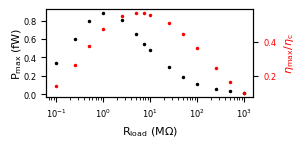

In [35]:
## Plot the results:

# Start by setting rc-params to match thesis design language
plt.rcdefaults() 
plt.rc('font', family='sans-serif', serif='Arial') 
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=8)
plt.rcParams['svg.fonttype'] = 'none'  # for svg: text saved as text.
# Figure dimensions:
figwidth = 2.62
figheight = 1.2

# Plot:
fig, ax = plt.subplots()
ax.set_position([0.2, 0.25, 0.79, 0.73]) # Manually set "data frame" size
    
plt.ylabel(r'P$_{\mathrm{max}}$ (fW)', labelpad=0)
plt.xlabel(r'R$_{\mathrm{load}}$ (M$\Omega$)')   

ax.plot(np.asarray(R_list)*1e-6, np.asarray(P_max_list)*1e15, 'o', c='black', ms=1.5)  
ax2 = ax.twinx()
ax2.set_position([0.2, 0.25, 0.79, 0.73]) # Manually set "data frame" size
ax2.tick_params(axis='y', labelcolor='red')
ax2.plot(np.asarray(R_list)*1e-6, n_max_list, 'o', c='red', ms=1.5)
ax2.set_ylabel('$\eta_{\mathrm{max}}/\eta_\mathrm{c}$', color='red')

plt.xscale('log')

fig.set_size_inches(figwidth, figheight)
plt.show()
plt.rcdefaults() 